# Flatiron Health mBC: Strict trials with GBM crude 

***OBJECTIVE:*** **Inclusion criteria for trials in other notebooks were relaxed to allow for as many patients to be included as reasonably possible. In this notebook, inclusion criteria for the trials will be followed as closely as possible. Patients included in our trials will next be risk stratified using the gradient boosted model with crude imputation into 1 of 3 risk groups: high (top tertile), medium (middle tertile), and low (bottom tertile). Inverse-probability treatment weighted survival analysis will then be performed across these risk groups to get real-world estimates of survival while adjusting for measured confounders.** 

***OUTLINE:***
1. **Identify patients with exclusion criteria:**
* Relevant comorbidities in the year preceding metastatic diagnosis 
* CNS metastasis at start of treatment   
* ECOG >2 at start of treatment 
* Organ dysfunction at start of treatment 

2. **In silico trials:**
* PALOMA-2 
* PALOMA-3
* CLEOPATRA

## Part 1: Identify patients with exclusion criteria

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Function that returns number of rows and count of unique PatientIDs for a dataframe. 
def row_ID(dataframe):
    row = dataframe.shape[0]
    ID = dataframe['PatientID'].nunique()
    return row, ID

In [3]:
train = pd.read_csv('train_full.csv')
row_ID(train)

(25341, 25341)

In [4]:
test = pd.read_csv('test_full.csv')
row_ID(test)

(6336, 6336)

In [5]:
df = pd.concat([train, test], ignore_index = True)
row_ID(df)

(31677, 31677)

### 1. Relevant comorbidities in the year preceding metastatic diagnosis 
* HIV, Hep B, or Hep C
* Psychosis and other significant psychiatric disorders 
* Uncontrolled hypertension 
* Unstable angina
* Myocardial infarction 
* CHF 

In [6]:
diagnosis = pd.read_csv('Diagnosis.csv')

In [7]:
diagnosis = diagnosis[diagnosis['PatientID'].isin(df['PatientID'])]       

In [8]:
diagnosis.loc[:, 'DiagnosisDate'] = pd.to_datetime(diagnosis['DiagnosisDate'])

In [9]:
enhanced_met = pd.read_csv('Enhanced_MetastaticBreast.csv')

In [10]:
enhanced_met.loc[:, 'MetDiagnosisDate'] = pd.to_datetime(enhanced_met['MetDiagnosisDate'])

In [11]:
row_ID(diagnosis)

(1575735, 31677)

In [12]:
diagnosis = pd.merge(diagnosis, enhanced_met[['PatientID', 'MetDiagnosisDate']], on = 'PatientID', how = 'left')

In [13]:
row_ID(diagnosis)

(1575735, 31677)

In [14]:
diagnosis.loc[:, 'date_diff'] = (diagnosis['DiagnosisDate'] - diagnosis['MetDiagnosisDate']).dt.days

In [15]:
diagnosis.loc[:, 'diagnosis_code'] = diagnosis['DiagnosisCode'].replace('\.', '', regex = True)

In [16]:
# ICD-9 dataframe with unique codes for each patient. 
diagnosis_9 = (
    diagnosis
    .query('date_diff <= 0 and date_diff > -365')
    .query('DiagnosisCodeSystem == "ICD-9-CM"')
    .drop_duplicates(subset = (['PatientID', 'DiagnosisCode']), keep = 'first')
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

In [17]:
other_comorb_9_IDs = (
    diagnosis_9[diagnosis_9['diagnosis_code'].str.match('042|'
                                                        '29[5789]')].PatientID.unique())

In [18]:
len(other_comorb_9_IDs)

4

In [19]:
cardiac_9_IDs = (
    diagnosis_9[diagnosis_9['diagnosis_code'].str.match('4010|'
                                                        '410|'
                                                        '412|'
                                                        '425')].PatientID.unique()
)

In [20]:
len(cardiac_9_IDs)

66

In [21]:
# ICD-9 dataframe with unique codes for each patient. 
diagnosis_10 = (
    diagnosis
    .query('date_diff <= 0 and  date_diff > -365')
    .query('DiagnosisCodeSystem == "ICD-10-CM"')
    .drop_duplicates(subset = (['PatientID', 'DiagnosisCode']), keep = 'first')
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

In [22]:
other_comorb_10_IDs = (
    diagnosis_10[diagnosis_10['diagnosis_code'].str.match('B20|'
                                                          'F2[024589]')].PatientID.unique())

In [23]:
len(other_comorb_10_IDs)

39

In [24]:
cardiac_10_IDs = (
    diagnosis_10[diagnosis_10['diagnosis_code'].str.match('I16|'
                                                          'I21|'
                                                          'I42')].PatientID.unique())

In [25]:
len(cardiac_10_IDs)

89

In [26]:
other_comorb_IDs = np.unique(np.concatenate([other_comorb_9_IDs, other_comorb_10_IDs]))

In [27]:
len(other_comorb_IDs)

43

In [28]:
cardiac_IDs = np.unique(np.concatenate([cardiac_9_IDs, cardiac_10_IDs]))

In [29]:
len(cardiac_IDs)

154

### 2. CNS metastasis at start of treatment 

In [30]:
mets = pd.read_csv('Enhanced_MetBreastSitesOfMet.csv')

In [31]:
mets = mets[mets['PatientID'].isin(df['PatientID'])]

In [32]:
mets.loc[:, 'DateOfMetastasis'] = pd.to_datetime(mets['DateOfMetastasis'])

In [33]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [34]:
line_therapy = line_therapy[line_therapy['PatientID'].isin(df['PatientID'])]       

In [35]:
line_therapy.loc[:, 'StartDate'] = pd.to_datetime(line_therapy['StartDate'])

In [36]:
therapy_fl = (
    line_therapy
    .query('LineNumber == 1')
    [['PatientID', 'StartDate']]
    .rename(columns = {'StartDate': 'StartDate_fl'}))

In [37]:
therapy_sec = (
    line_therapy
    .query('LineNumber == 2')
    [['PatientID', 'StartDate']]
    .rename(columns = {'StartDate': 'StartDate_sec'}))

In [38]:
row_ID(mets)

(78955, 31540)

In [39]:
mets_fl = pd.merge(mets, therapy_fl, on = 'PatientID', how = 'left')

In [40]:
row_ID(mets_fl)

(78955, 31540)

In [41]:
mets_sec = pd.merge(mets, therapy_sec, on = 'PatientID', how = 'left')

In [42]:
row_ID(mets_sec)

(78955, 31540)

In [43]:
cns_fl_IDs = (
    mets_fl
    .assign(date_diff_fl = (mets_fl['DateOfMetastasis'] - mets_fl['StartDate_fl']).dt.days)
    .query('date_diff_fl <= 0 and date_diff_fl > -90')
    .query('SiteOfMetastasis == "Brain" or SiteOfMetastasis == "CNS site"')
    .PatientID.unique()
)

In [44]:
len(cns_fl_IDs)

1498

In [45]:
cns_sec_IDs = (
    mets_sec
    .assign(date_diff_sec = (mets_sec['DateOfMetastasis'] - mets_sec['StartDate_sec']).dt.days)
    .query('date_diff_sec <= 0 and date_diff_sec > -90')
    .query('SiteOfMetastasis == "Brain" or SiteOfMetastasis == "CNS site"')
    .PatientID.unique()
)

In [46]:
len(cns_sec_IDs)

740

### 3. ECOG >2 at time of treatment  

In [47]:
base_ecog = pd.read_csv('BaselineECOG.csv')

In [48]:
base_ecog = base_ecog[base_ecog['PatientID'].isin(df['PatientID'])]       

In [49]:
ecog_fl_34_IDs = (
    base_ecog
    .query('LineNumber == 1')
    .query('ECOGValue == "3" or ECOGValue == "4"')
    .PatientID.unique())

In [50]:
len(ecog_fl_34_IDs)

826

In [51]:
ecog_fl_234_IDs = (
    base_ecog
    .query('LineNumber == 1')
    .query('ECOGValue == "2" or ECOGValue == "3" or ECOGValue == "4"')
    .PatientID.unique())

In [52]:
len(ecog_fl_234_IDs)

3063

In [53]:
ecog_sec_234_IDs = (
    base_ecog
    .query('LineNumber == 2')
    .query('ECOGValue == "2" or ECOGValue == "3" or ECOGValue == "4"')
    .PatientID.unique())

In [54]:
len(ecog_sec_234_IDs)

2216

### 4. Organ dysfunction at time of treatment
* Hemoglobin <9
* Creatinine >2
* Total bilirubin >3

In [55]:
lab = pd.read_csv('Lab.csv')

In [56]:
lab = lab[lab['PatientID'].isin(df['PatientID'])]

In [57]:
lab.loc[:, 'ResultDate'] = pd.to_datetime(lab['ResultDate']) 

In [58]:
row_ID(lab)

(30593212, 30259)

In [59]:
lab = pd.merge(lab, therapy_fl, on = 'PatientID', how = 'left')

In [60]:
row_ID(lab)

(30593212, 30259)

In [61]:
lab = pd.merge(lab, therapy_sec, on = 'PatientID', how = 'left')

In [62]:
# Select rows with clinically relevant labs.
lab_core = (
    lab[
    (lab['LOINC'] == "2160-0") |
    (lab['LOINC'] == "38483-4") | 
    (lab['LOINC'] == "718-7") |
    (lab['LOINC'] == "20509-6") |
    (lab['LOINC'] == "42719-5") |
    (lab['LOINC'] == "1975-2")]
    .filter(items = ['PatientID', 
                     'ResultDate', 
                     'LOINC', 
                     'LabComponent', 
                     'TestUnits', 
                     'TestUnitsCleaned', 
                     'TestResult', 
                     'TestResultCleaned', 
                     'StartDate_fl',
                     'StartDate_sec'])
)

In [63]:
conditions = [
    ((lab_core['LOINC'] == '2160-0') | (lab_core['LOINC'] == '38483-4')),
    ((lab_core['LOINC'] == '718-7') | (lab_core['LOINC'] == '20509-6')),
    ((lab_core['LOINC'] == '42719-5') | (lab_core['LOINC'] == '1975-2'))]

choices = ['creatinine', 
           'hemoglobin', 
           'total_bilirubin']

lab_core.loc[:, 'lab_name'] = np.select(conditions, choices)

In [64]:
row_ID(lab_core)

(2927968, 30127)

In [65]:
conditions = [
    (lab_core['lab_name'] == 'hemoglobin') & (lab_core['TestUnits'] == 'g/uL')]

choices = [lab_core['TestResultCleaned'] / 100000]

lab_core.loc[:, 'test_result_cleaned'] = np.select(conditions, choices, default = lab_core['TestResultCleaned'])

In [66]:
lab_fl = (
    lab_core
    .assign(date_diff_fl = (lab_core['ResultDate'] - lab_core['StartDate_fl']).dt.days)
    .query('date_diff_fl <= 0 and date_diff_fl > -90')
    .sort_values(by = ['PatientID', 'lab_name', 'date_diff_fl'], ascending = [True, True, False])
    .drop_duplicates(subset = ['PatientID', 'lab_name'], keep = 'first' )
)

In [67]:
# Select lab closest to date of advanced diagnosis and pivot to a wide table. 
lab_wide_fl = (
    lab_fl
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .reset_index())

lab_wide_fl.columns.name = None

In [68]:
lab_wide_fl.sample(3)

,PatientID,creatinine,hemoglobin,total_bilirubin
18775,FE5D72C42E661,0.60,13.1,0.4
849,F0A54AD57BB84,0.75,12.7,0.9
624,F07AF34058336,1.20,12.0,NaN


In [69]:
ab_organ_fl_IDs = lab_wide_fl.query('creatinine > 2 or hemoglobin < 9 or total_bilirubin > 3').PatientID

In [70]:
len(ab_organ_fl_IDs)

1053

In [71]:
lab_sec = (
    lab_core
    .assign(date_diff_sec = (lab_core['ResultDate'] - lab_core['StartDate_sec']).dt.days)
    .query('date_diff_sec <= 0 and date_diff_sec > -90')
    .sort_values(by = ['PatientID', 'lab_name', 'date_diff_sec'], ascending = [True, True, False])
    .drop_duplicates(subset = ['PatientID', 'lab_name'], keep = 'first' )
)

In [72]:
# Select lab closest to date of advanced diagnosis and pivot to a wide table. 
lab_wide_sec = (
    lab_sec
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .reset_index())

lab_wide_sec.columns.name = None

In [73]:
lab_wide_sec.sample(3)

,PatientID,creatinine,hemoglobin,total_bilirubin
15512,FF7A2052463BD,0.80,13.7,0.5
1903,F1EB2CB515404,NaN,12.7,NaN
2092,F21A77C5A5398,0.77,12.7,0.3


In [74]:
ab_organ_sec_IDs = lab_wide_sec.query('creatinine > 2 or hemoglobin < 9 or total_bilirubin > 3').PatientID

In [75]:
len(ab_organ_sec_IDs)

967

In [76]:
del diagnosis
del diagnosis_10
del diagnosis_9
del enhanced_met
del lab
del lab_core
del lab_fl
del lab_sec
del lab_wide_fl
del lab_wide_sec
del line_therapy
del therapy_fl
del therapy_sec

## Part 2: In-silico trials 

### Import packages and create necessary functions

In [77]:
import numpy as np
import pandas as pd

from scipy import stats

from sksurv.nonparametric import kaplan_meier_estimator
from survive import KaplanMeier, SurvivalData

from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.utils import median_survival_times

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.linear_model import LogisticRegression

from matplotlib.lines import Line2D   

In [78]:
# Find index for value closest to input value. 
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [79]:
cutoff = pd.read_csv('risk_cutoff_breast.csv', index_col = 0)

### PALOMA-2: palbociclib plus letrozole vs. letrozole in hormone-sensitive metastatic breast cancer

**INCLUSION**
* Untreated metastatic breast cancer
* Received first line palbociclib and aromatase inhibitor or aromatase inhibitor alone
* Luteinizing hormone–releasing hormone agonist (leuprolide, goserelin, and triptorelin) is allowed in either arm
* ER-positive within [-90, +30] days of first-line treatment
* HER-2 negative within [-90, +30] days of first-line treatment
* No relevant comorbidities in the year preceding metastatic diagnosis 
* No CNS metastasis at time of treatment 
* ECOG cannot be 3 or 4 at time of treatment 
* Adequate organ function at time of treatment 

#### Palbociclib plus AI 

In [80]:
df_full = pd.read_csv('df_risk_crude.csv', index_col = 'PatientID', dtype = {'death_status': bool})
df_full.index.nunique()

31677

In [81]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [82]:
line_therapy_fl = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1'))

In [83]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('Palbociclib')].LineName.value_counts().head(10)

Letrozole,Palbociclib                  2503
Fulvestrant,Palbociclib                1324
Anastrozole,Palbociclib                 466
Palbociclib                             261
Exemestane,Palbociclib                  123
Letrozole,Leuprolide,Palbociclib         98
Goserelin,Letrozole,Palbociclib          90
Fulvestrant,Letrozole,Palbociclib        40
Anastrozole,Fulvestrant,Palbociclib      37
Palbociclib,Tamoxifen                    31
Name: LineName, dtype: int64

In [84]:
# Of note, LH releasing hormone agonist (leuprolide, goserelin, and triptorelin) not excluded
ai = [
    'Anastrozole',
    'Letrozole',
    'Exemestane']

exc = [
    'Capecitabine',
    'Carboplatin',
    'Cisplatin',
    'Cyclophosphamide',
    'Cytarabine Liposomal',
    'Decitabine',
    'Docetaxel',
    'Doxorubicin',
    'Doxorubicin Pegylated Liposomal',
    'Eribulin',
    'Etoposide',
    'Fluorouracil',
    'Gemcitabine',
    'Hydroxyurea',
    'Leucovorin',
    'Methotrexate',
    'Oxaliplatin',
    'Paclitaxel',
    'Paclitaxel Protein-Bound',
    'Vinorelbine',
    'Nivolumab',
    'Pembrolizumab',
    'Abemaciclib',
    'Alpelisib',
    'Fulvestrant',
    'Ribociclib',
    'Tamoxifen',
    'Carfilzomib',
    'Daratumumab',
    'Everolimus',
    'Imatinib',
    'Lapatinib',
    'Lenalidomide',
    'Neratinib',
    'Olaparib',
    'Pazopanib',
    'Pertuzumab',
    'Rituximab',
    'Sorafenib',
    'Toremifene',
    'Trastuzumab',
    'Clinical Study Drug',
]

In [85]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('|'.join(ai)) & 
                line_therapy_fl['LineName'].str.contains('Palbociclib') &
                ~line_therapy_fl['LineName'].str.contains('|'.join(exc))].LineName.value_counts().head(30)

Letrozole,Palbociclib                  2503
Anastrozole,Palbociclib                 466
Exemestane,Palbociclib                  123
Letrozole,Leuprolide,Palbociclib         98
Goserelin,Letrozole,Palbociclib          90
Anastrozole,Goserelin,Palbociclib        17
Anastrozole,Leuprolide,Palbociclib       17
Letrozole,Palbociclib,Triptorelin         5
Anastrozole,Palbociclib,Triptorelin       4
Exemestane,Goserelin,Palbociclib          4
Exemestane,Leuprolide,Palbociclib         3
Name: LineName, dtype: int64

In [86]:
let_palb = (
    line_therapy_fl[line_therapy_fl['LineName'].str.contains('|'.join(ai)) & 
                    line_therapy_fl['LineName'].str.contains('Palbociclib') &
                    ~line_therapy_fl['LineName'].str.contains('|'.join(exc))]
    [['PatientID', 'StartDate']]
)

In [87]:
row_ID(let_palb)

(3330, 3330)

In [88]:
let_palb.loc[:,'let_palb'] = 1

#### AI

In [89]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('Letrozole')].LineName.value_counts().head(10)

Letrozole                            2536
Letrozole,Palbociclib                2503
Letrozole,Ribociclib                  229
Abemaciclib,Letrozole                 190
Letrozole,Leuprolide,Palbociclib       98
Goserelin,Letrozole,Palbociclib        90
Fulvestrant,Letrozole                  64
Letrozole,Trastuzumab                  59
Fulvestrant,Letrozole,Palbociclib      40
Letrozole,Leuprolide                   40
Name: LineName, dtype: int64

In [90]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('|'.join(ai)) & 
                ~line_therapy_fl['LineName'].str.contains('Palbociclib') &
                ~line_therapy_fl['LineName'].str.contains('|'.join(exc))].LineName.value_counts().head(40)

Anastrozole                      2943
Letrozole                        2536
Exemestane                        780
Letrozole,Leuprolide               40
Anastrozole,Leuprolide             35
Goserelin,Letrozole                26
Anastrozole,Goserelin              20
Exemestane,Goserelin                7
Exemestane,Leuprolide               4
Anastrozole,Triptorelin             2
Letrozole,Medroxyprogesterone       1
Letrozole,Triptorelin               1
Anastrozole,Megestrol               1
Name: LineName, dtype: int64

In [91]:
let = (
    line_therapy_fl[line_therapy_fl['LineName'].str.contains('|'.join(ai)) & 
                    ~line_therapy_fl['LineName'].str.contains('Palbociclib') &
                    ~line_therapy_fl['LineName'].str.contains('|'.join(exc))]
    [['PatientID', 'StartDate']]
)

In [92]:
row_ID(let)

(6396, 6396)

In [93]:
let.loc[:,'let_palb'] = 0

In [94]:
paloma2 = pd.concat([let_palb, let])

In [95]:
row_ID(paloma2)

(9726, 9726)

In [96]:
paloma2 = pd.merge(paloma2, df_full, on = 'PatientID', how = 'left')

In [97]:
row_ID(paloma2)

(9726, 9726)

In [98]:
paloma2['StartDate'] = pd.to_datetime(paloma2['StartDate'])

#### ER-positive and HER-2 negative 

In [99]:
biomarkers = pd.read_csv('Enhanced_MetBreastBiomarkers.csv')

In [100]:
biomarkers = biomarkers[biomarkers['PatientID'].isin(paloma2['PatientID'])]

In [101]:
row_ID(biomarkers)

(69754, 9662)

In [102]:
biomarkers = pd.merge(biomarkers, paloma2[['PatientID', 'StartDate']], on = 'PatientID', how = 'left')

In [103]:
row_ID(biomarkers)

(69754, 9662)

In [104]:
biomarkers['StartDate'] = pd.to_datetime(biomarkers['StartDate'])

In [105]:
biomarkers['ResultDate'] = pd.to_datetime(biomarkers['ResultDate'])

In [106]:
biomarkers['SpecimenReceivedDate'] = pd.to_datetime(biomarkers['SpecimenReceivedDate'])

In [107]:
biomarkers.loc[:, 'result_date'] = (
    np.where(biomarkers['ResultDate'].isna(), biomarkers['SpecimenReceivedDate'], biomarkers['ResultDate'])
)

In [108]:
biomarkers.loc[:, 'date_diff'] = (biomarkers['result_date'] - biomarkers['StartDate']).dt.days

In [109]:
er_status = (
    biomarkers
    .query('BiomarkerName == "ER"')
    .query('date_diff <= 30 and date_diff >= -90')
    .query('BiomarkerStatus == "Positive" or BiomarkerStatus == "Negative"') # don't select unknown values 
    .sort_values(['PatientID', 'date_diff'], ascending = [True, False]) # select ER status closest to treatment start
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    [['PatientID', 'BiomarkerStatus']]
    .rename(columns = {'BiomarkerStatus': 'er'})
   )

In [110]:
row_ID(er_status)

(6016, 6016)

In [111]:
her2_status = (
    biomarkers
    .query('BiomarkerName == "HER2"')
    .query('date_diff <= 30 and date_diff >= -90')
    .sort_values(['PatientID', 'date_diff'], ascending = [True, False])
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    [['PatientID', 'BiomarkerStatus']]
    .rename(columns = {'BiomarkerStatus': 'her2'})
)

In [112]:
row_ID(her2_status)

(5607, 5607)

In [113]:
paloma2 = pd.merge(paloma2, er_status, on  = 'PatientID', how = 'left')

In [114]:
row_ID(paloma2)

(9726, 9726)

In [115]:
paloma2 = pd.merge(paloma2, her2_status, on  = 'PatientID', how = 'left')

In [116]:
row_ID(paloma2)

(9726, 9726)

In [117]:
her2_neg = ['IHC negative (0-1+)',
            'FISH negative/not amplified',
            'IHC equivocal (2+)',
            'Negative NOS',
            'NGS negative (ERBB2 not amplified)',
            'FISH equivocal',
            'Equivocal NOS',
            'NGS equivocal (ERBB2 amplification equivocal)']

paloma2 = (
    paloma2
    .query('er == "Positive"')
    .query('her2== @her2_neg')
)

In [118]:
row_ID(paloma2)

(4842, 4842)

#### Time from treatment to progression/death or censor 

In [119]:
mortality_tr = pd.read_csv('mortality_cleaned_tr.csv')

In [120]:
mortality_te = pd.read_csv('mortality_cleaned_te.csv')

In [121]:
mortality_tr = mortality_tr[['PatientID', 'death_date', 'last_activity']]

In [122]:
mortality_te = mortality_te[['PatientID', 'death_date', 'last_activity']]

In [123]:
mortality = pd.concat([mortality_tr, mortality_te], ignore_index = True)
row_ID(mortality)

(31677, 31677)

In [124]:
mortality.loc[:, 'last_activity'] = pd.to_datetime(mortality['last_activity'])

In [125]:
mortality.loc[:, 'death_date'] = pd.to_datetime(mortality['death_date'])

In [126]:
row_ID(mortality)

(31677, 31677)

In [127]:
paloma2 = pd.merge(paloma2, mortality, on = 'PatientID', how = 'left')

In [128]:
row_ID(paloma2)

(4842, 4842)

In [129]:
progression = pd.read_csv ('Enhanced_MetBreastProgression.csv')

In [130]:
progression = progression[progression['PatientID'].isin(paloma2['PatientID'])][['PatientID', 'ProgressionDate']]

In [131]:
progression['ProgressionDate'] = pd.to_datetime(progression['ProgressionDate'])

In [132]:
progression = (
    progression
    .sort_values(['PatientID', 'ProgressionDate'], ascending = [True, True])
    .drop_duplicates(subset = 'PatientID', keep = 'first')
)

In [133]:
row_ID(progression)

(4840, 4840)

In [134]:
paloma2 = pd.merge(paloma2, progression, on = 'PatientID', how = 'left')

In [135]:
row_ID(paloma2)

(4842, 4842)

In [136]:
# Percent without progression date
len(paloma2.query('ProgressionDate.isna()', engine = 'python'))/len(paloma2)

0.4012804626187526

In [137]:
conditions = [
    (paloma2.ProgressionDate.notna()),
    ((paloma2.ProgressionDate.isna()) & (paloma2['death_status'] == 1)),
    ((paloma2.ProgressionDate.isna()) & (paloma2['death_status'] == 0))]

choices = [
    (paloma2['ProgressionDate'] - paloma2['StartDate']).dt.days,
    (paloma2['death_date'] - paloma2['StartDate']).dt.days,
    (paloma2['last_activity'] - paloma2['StartDate']).dt.days]

paloma2.loc[:, 'time_prog_treatment'] = np.select(conditions, choices)

In [138]:
paloma2 = paloma2.query('time_prog_treatment >= 0')

In [139]:
len(paloma2)

4734

In [140]:
conditions = [
    (paloma2.ProgressionDate.notna()),
    ((paloma2.ProgressionDate.isna()) & (paloma2['death_status'] == 1)),
    ((paloma2.ProgressionDate.isna()) & (paloma2['death_status'] == 0))]

choices = [1, 1, 0]

paloma2.loc[:, 'pfs_status'] = np.select(conditions, choices)

#### Patient count 

In [141]:
row_ID(paloma2)

(4734, 4734)

In [142]:
# Exlcude those with other relevant comorbidities
paloma2 = paloma2[~paloma2['PatientID'].isin(other_comorb_IDs)]

In [143]:
# Exclude those with CNS metastatsis at time of first line treatment
paloma2 = paloma2[~paloma2['PatientID'].isin(cns_fl_IDs)]

In [144]:
# Exclude those with ECOG 3 or 4  
paloma2 = paloma2[~paloma2['PatientID'].isin(ecog_fl_34_IDs)]

In [145]:
# Exclude those with abnormal organ function at time of first line treatment 
paloma2 = paloma2[~paloma2['PatientID'].isin(ab_organ_fl_IDs)]

In [146]:
row_ID(paloma2)

(4276, 4276)

In [147]:
low_cutoff_paloma2 = cutoff.loc['paloma2'].low

In [148]:
high_cutoff_paloma2 = cutoff.loc['paloma2'].high

In [149]:
print('Palbociclib plus letrozole total:',  paloma2.query('let_palb == 1').shape[0])
print('High risk:', paloma2.query('let_palb == 1').query('risk_score >= @high_cutoff_paloma2').shape[0])
print('Med risk:', paloma2.query('let_palb == 1').query('risk_score < @high_cutoff_paloma2 and risk_score > @low_cutoff_paloma2').shape[0])
print('Low risk:', paloma2.query('let_palb == 1').query('risk_score <= @low_cutoff_paloma2').shape[0])

Palbociclib plus letrozole total: 1961
High risk: 505
Med risk: 637
Low risk: 819


In [150]:
print('Letrozole:',  paloma2.query('let_palb == 0').shape[0])
print('High risk:', paloma2.query('let_palb == 0').query('risk_score >= @high_cutoff_paloma2').shape[0])
print('Med risk:', paloma2.query('let_palb == 0').query('risk_score < @high_cutoff_paloma2 and risk_score > @low_cutoff_paloma2').shape[0])
print('Low risk:', paloma2.query('let_palb == 0').query('risk_score <= @low_cutoff_paloma2').shape[0])

Letrozole: 2315
High risk: 762
Med risk: 836
Low risk: 717


#### PFS curves with covariate balancing 

In [151]:
paloma2 = paloma2.set_index('PatientID')

In [152]:
conditions = [
    (paloma2['thorax_met'] == 1) |
    (paloma2['liver_met'] == 1) |
    (paloma2['cns_met'] == 1) |
    (paloma2['peritoneum_met'] == 1) |
    (paloma2['other_met'] == 1),
    (paloma2['bone_met'] == 0) &
    (paloma2['thorax_met'] == 0) &
    (paloma2['lymph_met'] == 0) &
    (paloma2['liver_met'] == 0) &
    (paloma2['cns_met'] == 0) &
    (paloma2['skin_met'] == 0) &
    (paloma2['peritoneum_met'] == 0) &
    (paloma2['other_met'] == 0)
]

choices = ['visceral', 'unknown']

paloma2['met_site'] = np.select(conditions, choices, default = 'nonvisceral')

In [153]:
paloma2['met_cat'] = pd.cut(paloma2['met_year'],
                            bins = [2010, 2016, float('inf')],
                            labels = ['11-16', '17-22'])

In [154]:
conditions = [
    ((paloma2['ecog_diagnosis'] == "1.0") | (paloma2['ecog_diagnosis'] == "0.0")),  
    ((paloma2['ecog_diagnosis'] == "2.0") | (paloma2['ecog_diagnosis'] == "3.0"))
]

choices = ['lt_2', 'gte_2']

paloma2['ecog_2'] = np.select(conditions, choices, default = 'unknown')

In [155]:
paloma2_iptw = paloma2.filter(items = ['pfs_status',
                                       'time_prog_treatment',
                                       'let_palb',
                                       'age',
                                       'gender',
                                       'race',
                                       'p_type',
                                       'delta_met_diagnosis',
                                       'met_cat',
                                       'commercial',
                                       'medicare',
                                       'medicaid',
                                       'ses',
                                       'ecog_2',
                                       'met_site',
                                       'albumin_diag',
                                       'weight_pct_change',
                                       'risk_score'])

In [156]:
paloma2_iptw.dtypes

pfs_status                int64
time_prog_treatment     float64
let_palb                  int64
age                       int64
gender                   object
race                     object
p_type                   object
delta_met_diagnosis       int64
met_cat                category
commercial              float64
medicare                float64
medicaid                float64
ses                     float64
ecog_2                   object
met_site                 object
albumin_diag            float64
weight_pct_change       float64
risk_score              float64
dtype: object

In [157]:
to_be_categorical = list(paloma2_iptw.select_dtypes(include = ['object']).columns)

In [158]:
to_be_categorical

['gender', 'race', 'p_type', 'ecog_2', 'met_site']

In [159]:
to_be_categorical.append('met_cat')

In [160]:
to_be_categorical.append('ses')

In [161]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    paloma2_iptw[x] = paloma2_iptw[x].astype('category')

In [162]:
# List of numeric variables, excluding binary variables. 
numerical_features = ['age', 'delta_met_diagnosis', 'albumin_diag', 'weight_pct_change', 'risk_score']

# Transformer will first calculate column median and impute, and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [163]:
# List of categorical features.
categorical_features = list(paloma2_iptw.select_dtypes(include = ['category']).columns)

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [164]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

In [165]:
paloma2_iptw_low = (
    paloma2_iptw
    .query('risk_score <= @low_cutoff_paloma2'))

paloma2_iptw_med = (
    paloma2_iptw
    .query('risk_score < @high_cutoff_paloma2 and risk_score > @low_cutoff_paloma2'))

paloma2_iptw_high = (
    paloma2_iptw
    .query('risk_score >= @high_cutoff_paloma2'))

paloma2_iptw_all = paloma2_iptw

In [166]:
paloma2_low_x = preprocessor.fit_transform(paloma2_iptw_low.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'p_type',
                                                                            'delta_met_diagnosis',
                                                                            'met_cat',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ses',
                                                                            'ecog_2',
                                                                            'met_site', 
                                                                            'albumin_diag', 
                                                                            'weight_pct_change', 
                                                                            'risk_score']))

paloma2_med_x = preprocessor.fit_transform(paloma2_iptw_med.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'p_type',
                                                                            'delta_met_diagnosis',
                                                                            'met_cat',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ses',
                                                                            'ecog_2',
                                                                            'met_site', 
                                                                            'albumin_diag', 
                                                                            'weight_pct_change', 
                                                                            'risk_score']))

paloma2_high_x = preprocessor.fit_transform(paloma2_iptw_high.filter(items = ['age',
                                                                              'gender',
                                                                              'race',
                                                                              'p_type',
                                                                              'delta_met_diagnosis',
                                                                              'met_cat',
                                                                              'commercial',
                                                                              'medicare',
                                                                              'medicaid',
                                                                              'ses',
                                                                              'ecog_2',
                                                                              'met_site', 
                                                                              'albumin_diag', 
                                                                              'weight_pct_change', 
                                                                              'risk_score']))

paloma2_all_x = preprocessor.fit_transform(paloma2_iptw_all.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'p_type',
                                                                            'delta_met_diagnosis',
                                                                            'met_cat',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ses',
                                                                            'ecog_2',
                                                                            'met_site', 
                                                                            'albumin_diag', 
                                                                            'weight_pct_change', 
                                                                            'risk_score']))

In [167]:
lr_paloma2_low = LogisticRegression(max_iter = 1000)
lr_paloma2_low.fit(paloma2_low_x, paloma2_iptw_low['let_palb'])

LogisticRegression(max_iter=1000)

In [168]:
lr_paloma2_med = LogisticRegression(max_iter = 1000)
lr_paloma2_med.fit(paloma2_med_x, paloma2_iptw_med['let_palb'])

LogisticRegression(max_iter=1000)

In [169]:
lr_paloma2_high = LogisticRegression(max_iter = 1000)
lr_paloma2_high.fit(paloma2_high_x, paloma2_iptw_high['let_palb'])

LogisticRegression(max_iter=1000)

In [170]:
lr_paloma2_all = LogisticRegression(max_iter = 1000)
lr_paloma2_all.fit(paloma2_all_x, paloma2_iptw_all['let_palb'])

LogisticRegression(max_iter=1000)

In [171]:
pred_low = lr_paloma2_low.predict_proba(paloma2_low_x)
pred_med = lr_paloma2_med.predict_proba(paloma2_med_x)
pred_high = lr_paloma2_high.predict_proba(paloma2_high_x)
pred_all = lr_paloma2_all.predict_proba(paloma2_all_x)

In [172]:
paloma2_iptw_low['ps'] = pred_low[:, 1]
paloma2_iptw_med['ps'] = pred_med[:, 1]
paloma2_iptw_high['ps'] = pred_high[:, 1]
paloma2_iptw_all['ps'] = pred_all[:, 1]

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [173]:
paloma2_iptw_low['weight'] = (
    np.where(paloma2_iptw_low['let_palb'] == 1, 1/paloma2_iptw_low['ps'], 1/(1 - paloma2_iptw_low['ps'])))

paloma2_iptw_med['weight'] = (
    np.where(paloma2_iptw_med['let_palb'] == 1, 1/paloma2_iptw_med['ps'], 1/(1 - paloma2_iptw_med['ps'])))

paloma2_iptw_high['weight'] = (
    np.where(paloma2_iptw_high['let_palb'] == 1, 1/paloma2_iptw_high['ps'], 1/(1 - paloma2_iptw_high['ps'])))

paloma2_iptw_all['weight'] = (
    np.where(paloma2_iptw_all['let_palb'] == 1, 1/paloma2_iptw_all['ps'], 1/(1 - paloma2_iptw_all['ps'])))

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [174]:
# Low KM curves
kmf_low_plet_paloma2_iptw = KaplanMeierFitter()
kmf_low_let_paloma2_iptw = KaplanMeierFitter()

kmf_low_plet_paloma2_iptw.fit(
    paloma2_iptw_low.query('let_palb == 1').time_prog_treatment/30,
    paloma2_iptw_low.query('let_palb == 1').pfs_status,
    weights = paloma2_iptw_low.query('let_palb == 1')['weight'])

kmf_low_let_paloma2_iptw.fit(
    paloma2_iptw_low.query('let_palb == 0').time_prog_treatment/30,
    paloma2_iptw_low.query('let_palb == 0').pfs_status,
    weights = paloma2_iptw_low.query('let_palb == 0')['weight'])

# Med KM curves
kmf_med_plet_paloma2_iptw = KaplanMeierFitter()
kmf_med_let_paloma2_iptw = KaplanMeierFitter()

kmf_med_plet_paloma2_iptw.fit(
    paloma2_iptw_med.query('let_palb == 1').time_prog_treatment/30,
    paloma2_iptw_med.query('let_palb == 1').pfs_status,
    weights = paloma2_iptw_med.query('let_palb == 1')['weight'])

kmf_med_let_paloma2_iptw.fit(
    paloma2_iptw_med.query('let_palb == 0').time_prog_treatment/30,
    paloma2_iptw_med.query('let_palb == 0').pfs_status,
    weights = paloma2_iptw_med.query('let_palb == 0')['weight'])

# High KM curves 
kmf_high_plet_paloma2_iptw = KaplanMeierFitter()
kmf_high_let_paloma2_iptw = KaplanMeierFitter()

kmf_high_plet_paloma2_iptw.fit(
    paloma2_iptw_high.query('let_palb == 1').time_prog_treatment/30,
    paloma2_iptw_high.query('let_palb == 1').pfs_status,
    weights = paloma2_iptw_high.query('let_palb == 1')['weight'])

kmf_high_let_paloma2_iptw.fit(
    paloma2_iptw_high.query('let_palb == 0').time_prog_treatment/30,
    paloma2_iptw_high.query('let_palb == 0').pfs_status,
    weights = paloma2_iptw_high.query('let_palb == 0')['weight'])

# All KM curves 
kmf_all_plet_paloma2_iptw = KaplanMeierFitter()
kmf_all_let_paloma2_iptw = KaplanMeierFitter()

kmf_all_plet_paloma2_iptw.fit(
    paloma2_iptw_all.query('let_palb == 1').time_prog_treatment/30,
    paloma2_iptw_all.query('let_palb == 1').pfs_status,
    weights = paloma2_iptw_all.query('let_palb == 1')['weight'])

kmf_all_let_paloma2_iptw.fit(
    paloma2_iptw_all.query('let_palb == 0').time_prog_treatment/30,
    paloma2_iptw_all.query('let_palb == 0').pfs_status,
    weights = paloma2_iptw_all.query('let_palb == 0')['weight'])

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:344: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  StatisticalWarning,


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 4281.25 total observations, 1071.13 right-censored observations>

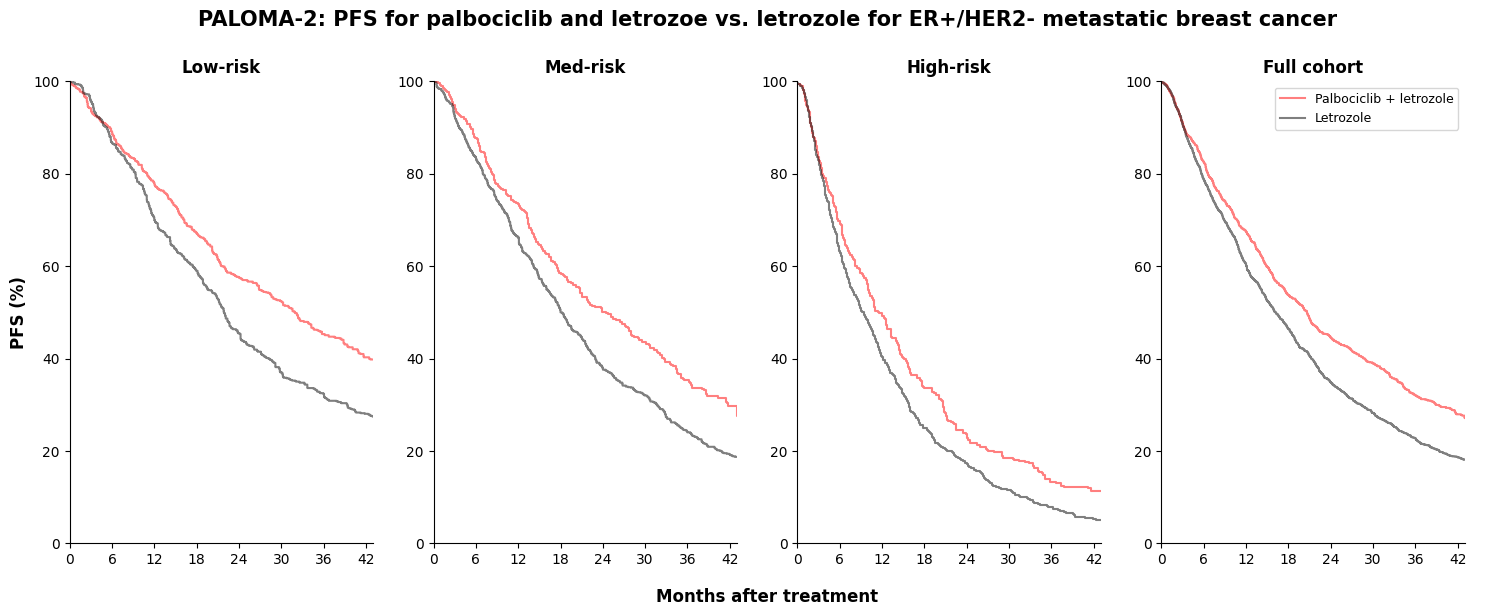

In [175]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

plt.step(kmf_low_plet_paloma2_iptw.timeline, kmf_low_plet_paloma2_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_low_let_paloma2_iptw.timeline, kmf_low_let_paloma2_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('PFS (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves for med risk group. 
plt.subplot(1, 4, 2)

plt.step(kmf_med_plet_paloma2_iptw.timeline, kmf_med_plet_paloma2_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_med_let_paloma2_iptw.timeline, kmf_med_let_paloma2_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

plt.step(kmf_high_plet_paloma2_iptw.timeline, kmf_high_plet_paloma2_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_high_let_paloma2_iptw.timeline, kmf_high_let_paloma2_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for all risk group. 
plt.subplot(1, 4, 4)

plt.step(kmf_all_plet_paloma2_iptw.timeline, kmf_all_plet_paloma2_iptw.survival_function_.values*100, color = 'red', alpha = 0.5, label = 'Palbociclib + letrozole')

plt.step(kmf_all_let_paloma2_iptw.timeline, kmf_all_let_paloma2_iptw.survival_function_.values*100, color = 'black', alpha = 0.5, label = 'Letrozole')

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'upper right', prop = {'size': 9})

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title('PALOMA-2: PFS for palbociclib and letrozoe vs. letrozole for ER+/HER2- metastatic breast cancer', pad = 40, size = 15, weight = 'bold')

plt.show()

### PALOMA-3: palbociclib plus fulvestrant vs. fulvestrant in hormone-sensitive metastatic breast cancer that had previously progressed on endocrine therapy

**INCLUSION**
* Received first line estrogen therapy +/ one line of chemotherapy 
* Received second (or third) line palbociclib plus fulvestrant or fulvestrant alone 
* Did not receive CDK 4/6 inhibitor, fulvestrant, or everolimus in earlier lines
* ER/PR positive and HER-2 negative within (-inf, +30] days of start of treatment
* No relevant comorbidities in the year preceding metastatic diagnosis 
* No CNS metastasis at time of treatment 
* ECOG cannot be 2, 3, or 4 at time of treatment 
* Adequate organ function at time of treatment 

#### 1. First line endorcine therapy + chemotherapy, second line fulvestrant +/- palbociclib

In [176]:
df_full = pd.read_csv('df_risk_crude.csv', index_col = 'PatientID', dtype = {'death_status': bool})
df_full.index.nunique()

31677

In [177]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [178]:
line_therapy_fl = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1'))

In [179]:
et = [
    'Anastrozole',
    'Letrozole',
    'Exemestane',
    'Tamoxifen',
    'Leuprolide',
    'Goserelin',
    'Triptorelin',
    'Buserelin']

chemo = [
    'Capecitabine',
    'Carboplatin',
    'Cyclophosphamide',
    'Docetaxel',
    'Eribulin',
    'Gemcitabine',
    'Paclitaxel',
    'Paclitaxel Protein-Bound',
    'Vinorelbine']

exc =[
    'Abemaciclib',
    'Palbociclib',
    'Ribociclib',
    'Fulvestrant',
    'Everolimus',
    'Clinical Study Drug']

In [180]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('|'.join(et)) 
                & line_therapy_fl['LineName'].str.contains('|'.join(chemo))
                & ~line_therapy_fl['LineName'].str.contains('|'.join(exc))].LineName.value_counts().head(10)

Capecitabine,Letrozole                        31
Anastrozole,Capecitabine                      25
Anastrozole,Paclitaxel                        18
Letrozole,Paclitaxel Protein-Bound            17
Anastrozole,Paclitaxel Protein-Bound          14
Capecitabine,Tamoxifen                        14
Capecitabine,Exemestane                       13
Letrozole,Paclitaxel                          13
Docetaxel,Letrozole,Pertuzumab,Trastuzumab    11
Paclitaxel,Tamoxifen                          11
Name: LineName, dtype: int64

In [181]:
etchemo_id = (
    line_therapy_fl
    [line_therapy_fl['LineName'].str.contains('|'.join(et))
     & line_therapy_fl['LineName'].str.contains('|'.join(chemo))
     & ~line_therapy_fl['LineName'].str.contains('|'.join(exc))]
    .PatientID
)

In [182]:
line_therapy_sec = (
    line_therapy[line_therapy['PatientID'].isin(etchemo_id)]
    .query('LineNumber == 2'))

In [183]:
etchemo_pf = (
    line_therapy_sec
    .query('LineName == "Fulvestrant,Palbociclib"')
    [['PatientID', 'StartDate']]
)

In [184]:
row_ID(etchemo_pf)

(16, 16)

In [185]:
etchemo_f = (
    line_therapy_sec
    .query('LineName == "Fulvestrant"')
    [['PatientID', 'StartDate']]
)

In [186]:
row_ID(etchemo_pf)

(16, 16)

#### 2. First line endocrine therapy,  second line chemotherapy, third line palbociclib + fulvestrant

In [187]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('|'.join(et)) 
                & ~line_therapy_fl['LineName'].str.contains('|'.join(chemo))
                & ~line_therapy_fl['LineName'].str.contains('|'.join(exc))].LineName.value_counts().head(10)

Anastrozole                2943
Letrozole                  2536
Tamoxifen                  1305
Exemestane                  780
Leuprolide                   77
Anastrozole,Trastuzumab      66
Goserelin                    60
Letrozole,Trastuzumab        59
Leuprolide,Tamoxifen         56
Letrozole,Leuprolide         40
Name: LineName, dtype: int64

In [188]:
et_id = (
    line_therapy_fl
    [line_therapy_fl['LineName'].str.contains('|'.join(et))
     & ~line_therapy_fl['LineName'].str.contains('|'.join(chemo))
     & ~line_therapy_fl['LineName'].str.contains('|'.join(exc))]
    .PatientID
)

In [189]:
line_therapy_sec = (
    line_therapy[line_therapy['PatientID'].isin(et_id)]
    .query('LineNumber == 2')
)

In [190]:
et_chemo_id = (
    line_therapy_sec
    [line_therapy_sec['LineName'].str.contains('|'.join(chemo))
     & ~line_therapy_sec['LineName'].str.contains('|'.join(exc))]
    .PatientID
)

In [191]:
et_chemo_pf = (
    line_therapy[line_therapy['PatientID'].isin(et_chemo_id)]
    .query('LineNumber == 3')
    .query('LineName == "Fulvestrant,Palbociclib"')
    [['PatientID', 'StartDate']]
)

In [192]:
row_ID(et_chemo_pf)

(34, 34)

In [193]:
et_chemo_f = (
    line_therapy[line_therapy['PatientID'].isin(et_chemo_id)]
    .query('LineNumber == 3')
    .query('LineName == "Fulvestrant"')
    [['PatientID', 'StartDate']]
)

In [194]:
row_ID(et_chemo_f)

(57, 57)

#### 3. First line chemotherapy, second line endocrine therapy, third line palbociclib + fulvestrant

In [195]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('|'.join(chemo)) 
                & ~line_therapy_fl['LineName'].str.contains('|'.join(et))
                & ~line_therapy_fl['LineName'].str.contains('|'.join(exc))].LineName.value_counts().head(10)

Capecitabine                             1324
Cyclophosphamide,Doxorubicin              690
Docetaxel,Pertuzumab,Trastuzumab          676
Paclitaxel                                589
Paclitaxel Protein-Bound                  584
Carboplatin,Gemcitabine                   407
Paclitaxel,Pertuzumab,Trastuzumab         289
Eribulin                                  261
Carboplatin,Paclitaxel                    250
Atezolizumab,Paclitaxel Protein-Bound     226
Name: LineName, dtype: int64

In [196]:
chemo_id = (
    line_therapy_fl
    [line_therapy_fl['LineName'].str.contains('|'.join(chemo))
     & ~line_therapy_fl['LineName'].str.contains('|'.join(et))
     & ~line_therapy_fl['LineName'].str.contains('|'.join(exc))]
    .PatientID
)

In [197]:
line_therapy_sec = (
    line_therapy[line_therapy['PatientID'].isin(chemo_id)]
    .query('LineNumber == 2')
)

In [198]:
chemo_et_id = (
    line_therapy_sec
    [line_therapy_sec['LineName'].str.contains('|'.join(et))
     & ~line_therapy_sec['LineName'].str.contains('|'.join(exc))]
    .PatientID
)

In [199]:
chemo_et_pf = (
    line_therapy[line_therapy['PatientID'].isin(chemo_et_id)]
    .query('LineNumber == 3')
    .query('LineName == "Fulvestrant,Palbociclib"')
    [['PatientID', 'StartDate']]
)

In [200]:
row_ID(chemo_et_pf)

(39, 39)

In [201]:
chemo_et_f = (
    line_therapy[line_therapy['PatientID'].isin(chemo_et_id)]
    .query('LineNumber == 3')
    .query('LineName == "Fulvestrant"')
    [['PatientID', 'StartDate']]
)

In [202]:
row_ID(chemo_et_f)

(43, 43)

#### 4. First line endocrine therapy, second line palbociclib + fulvestrant

In [203]:
et_pf = (
    line_therapy[line_therapy['PatientID'].isin(et_id)]
    .query('LineNumber == 2')
    .query('LineName == "Fulvestrant,Palbociclib"')
    [['PatientID', 'StartDate']]
)

In [204]:
row_ID(et_pf)

(440, 440)

In [205]:
et_f = (
    line_therapy[line_therapy['PatientID'].isin(et_id)]
    .query('LineNumber == 2')
    .query('LineName == "Fulvestrant"')
    [['PatientID', 'StartDate']]
)

In [206]:
row_ID(et_f)

(786, 786)

In [207]:
paloma3_pf = pd.concat([etchemo_pf, et_chemo_pf, chemo_et_pf, et_pf])

In [208]:
paloma3_pf.loc[:, 'pfulv'] = 1

In [209]:
row_ID(paloma3_pf)

(529, 529)

In [210]:
paloma3_f = pd.concat([etchemo_f, et_chemo_f, chemo_et_f, et_f])

In [211]:
paloma3_f.loc[:, 'pfulv'] = 0

In [212]:
row_ID(paloma3_f)

(902, 902)

In [213]:
paloma3 = pd.concat([paloma3_pf, paloma3_f])

In [214]:
row_ID(paloma3)

(1431, 1431)

In [215]:
paloma3 = pd.merge(paloma3, df_full, on = 'PatientID', how = 'left')

In [216]:
row_ID(paloma3)

(1431, 1431)

In [217]:
paloma3['StartDate'] = pd.to_datetime(paloma3['StartDate'])

#### ER- or PR-positive and HER-2 negative 

In [218]:
biomarkers = pd.read_csv('Enhanced_MetBreastBiomarkers.csv')

In [219]:
biomarkers = biomarkers[biomarkers['PatientID'].isin(paloma3['PatientID'])]

In [220]:
row_ID(biomarkers)

(10689, 1426)

In [221]:
biomarkers = pd.merge(biomarkers, paloma3[['PatientID', 'StartDate']], on = 'PatientID', how = 'left')

In [222]:
row_ID(biomarkers)

(10689, 1426)

In [223]:
biomarkers['StartDate'] = pd.to_datetime(biomarkers['StartDate'])

In [224]:
biomarkers['ResultDate'] = pd.to_datetime(biomarkers['ResultDate'])

In [225]:
biomarkers['SpecimenReceivedDate'] = pd.to_datetime(biomarkers['SpecimenReceivedDate'])

In [226]:
biomarkers.loc[:, 'result_date'] = (
    np.where(biomarkers['ResultDate'].isna(), biomarkers['SpecimenReceivedDate'], biomarkers['ResultDate'])
)

In [227]:
biomarkers.loc[:, 'date_diff'] = (biomarkers['result_date'] - biomarkers['StartDate']).dt.days

In [228]:
er_status = (
    biomarkers
    .query('BiomarkerName == "ER"')
    .query('date_diff <= 30')
    .query('BiomarkerStatus == "Positive" or BiomarkerStatus == "Negative"') # don't select unknown values 
    .sort_values(['PatientID', 'date_diff'], ascending = [True, False]) # select ER status closest to treatment start
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    [['PatientID', 'BiomarkerStatus']]
    .rename(columns = {'BiomarkerStatus': 'er'})
   )

In [229]:
row_ID(er_status)

(1293, 1293)

In [230]:
pr_status = (
    biomarkers
    .query('BiomarkerName == "PR"')
    .query('date_diff <= 30')
    .query('BiomarkerStatus == "Positive" or BiomarkerStatus == "Negative"') # don't select unknown values 
    .sort_values(['PatientID', 'date_diff'], ascending = [True, False]) # select ER status closest to treatment start
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    [['PatientID', 'BiomarkerStatus']]
    .rename(columns = {'BiomarkerStatus': 'pr'})
   )

In [231]:
row_ID(pr_status)

(1253, 1253)

In [232]:
her2_status = (
    biomarkers
    .query('BiomarkerName == "HER2"')
    .query('date_diff <= 30')
    .sort_values(['PatientID', 'date_diff'], ascending = [True, False])
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    [['PatientID', 'BiomarkerStatus']]
    .rename(columns = {'BiomarkerStatus': 'her2'})
)

In [233]:
row_ID(her2_status)

(1245, 1245)

In [234]:
paloma3 = pd.merge(paloma3, er_status, on  = 'PatientID', how = 'left')

In [235]:
row_ID(paloma3)

(1431, 1431)

In [236]:
paloma3 = pd.merge(paloma3, pr_status, on  = 'PatientID', how = 'left')

In [237]:
row_ID(paloma3)

(1431, 1431)

In [238]:
paloma3 = pd.merge(paloma3, her2_status, on  = 'PatientID', how = 'left')

In [239]:
row_ID(paloma3)

(1431, 1431)

In [240]:
her2_neg = ['IHC negative (0-1+)',
            'FISH negative/not amplified',
            'IHC equivocal (2+)',
            'Negative NOS',
            'NGS negative (ERBB2 not amplified)',
            'FISH equivocal',
            'Equivocal NOS',
            'NGS equivocal (ERBB2 amplification equivocal)']

paloma3 = (
    paloma3
    .query('er == "Positive" or pr == "Positive"')
    .query('her2== @her2_neg')
)

In [241]:
row_ID(paloma3)

(1161, 1161)

#### Time from treatment to progression/death or censor 

In [242]:
mortality_tr = pd.read_csv('mortality_cleaned_tr.csv')

In [243]:
mortality_te = pd.read_csv('mortality_cleaned_te.csv')

In [244]:
mortality_tr = mortality_tr[['PatientID', 'death_date', 'last_activity']]

In [245]:
mortality_te = mortality_te[['PatientID', 'death_date', 'last_activity']]

In [246]:
mortality = pd.concat([mortality_tr, mortality_te], ignore_index = True)
row_ID(mortality)

(31677, 31677)

In [247]:
mortality.loc[:, 'last_activity'] = pd.to_datetime(mortality['last_activity'])

In [248]:
mortality.loc[:, 'death_date'] = pd.to_datetime(mortality['death_date'])

In [249]:
row_ID(mortality)

(31677, 31677)

In [250]:
paloma3 = pd.merge(paloma3, mortality, on = 'PatientID', how = 'left')

In [251]:
row_ID(paloma3)

(1161, 1161)

In [252]:
conditions = [
    (paloma3['death_status'] == 1),
    (paloma3['death_status'] == 0)]

choices = [
    (paloma3['death_date'] - paloma3['StartDate']).dt.days,
    (paloma3['last_activity'] - paloma3['StartDate']).dt.days]

paloma3.loc[:, 'timerisk_treatment'] = np.select(conditions, choices)

In [253]:
paloma3 = paloma3.query('timerisk_treatment >= 0')

#### Patient count 

In [254]:
row_ID(paloma3)

(1161, 1161)

In [255]:
# Exclude those with CNS metastatsis at time of metastatic diagnosis 
paloma3 = paloma3[~paloma3['PatientID'].isin(cns_sec_IDs)]

In [256]:
# Exlcude those with other relevant comorbidities
paloma3 = paloma3[~paloma3['PatientID'].isin(other_comorb_IDs)]

In [257]:
# Exclude those with ECOG 2, 3, or 4 
paloma3 = paloma3[~paloma3['PatientID'].isin(ecog_sec_234_IDs)]

In [258]:
# Exclude those with abnormal organ function at time of second line treatment 
paloma3 = paloma3[~paloma3['PatientID'].isin(ab_organ_sec_IDs)]

In [259]:
row_ID(paloma3)

(948, 948)

In [260]:
low_cutoff_paloma3 = cutoff.loc['paloma3'].low

In [261]:
high_cutoff_paloma3 = cutoff.loc['paloma3'].high

In [262]:
print('Palobociclib plus fulvestrant total:',  paloma3.query('pfulv == 1').shape[0])
print('High risk:', paloma3.query('pfulv == 1').query('risk_score >= @high_cutoff_paloma3').shape[0])
print('Med risk:', paloma3.query('pfulv == 1').query('risk_score < @high_cutoff_paloma3 and risk_score > @low_cutoff_paloma3').shape[0])
print('Low risk:', paloma3.query('pfulv == 1').query('risk_score <= @low_cutoff_paloma3').shape[0])

Palobociclib plus fulvestrant total: 387
High risk: 108
Med risk: 131
Low risk: 148


In [263]:
print('Fulvestrant total:',  paloma3.query('pfulv == 0').shape[0])
print('High risk:', paloma3.query('pfulv == 0').query('risk_score >= @high_cutoff_paloma3').shape[0])
print('Med risk:', paloma3.query('pfulv == 0').query('risk_score < @high_cutoff_paloma3 and risk_score > @low_cutoff_paloma3').shape[0])
print('Low risk:', paloma3.query('pfulv == 0').query('risk_score <= @low_cutoff_paloma3').shape[0])

Fulvestrant total: 561
High risk: 161
Med risk: 197
Low risk: 203


#### Survival curves with covariate balancing 

In [264]:
paloma3 = paloma3.set_index('PatientID')

In [265]:
conditions = [
    (paloma3['thorax_met'] == 1) |
    (paloma3['liver_met'] == 1) |
    (paloma3['cns_met'] == 1) |
    (paloma3['peritoneum_met'] == 1) |
    (paloma3['other_met'] == 1),
    (paloma3['bone_met'] == 0) &
    (paloma3['thorax_met'] == 0) &
    (paloma3['lymph_met'] == 0) &
    (paloma3['liver_met'] == 0) &
    (paloma3['cns_met'] == 0) &
    (paloma3['skin_met'] == 0) &
    (paloma3['peritoneum_met'] == 0) &
    (paloma3['other_met'] == 0)
]

choices = ['visceral', 'unknown']

paloma3['met_site'] = np.select(conditions, choices, default = 'nonvisceral')

In [266]:
paloma3['met_cat'] = pd.cut(paloma3['met_year'],
                            bins = [2010, 2016, float('inf')],
                            labels = ['11-16', '17-22'])

In [267]:
conditions = [
    ((paloma3['ecog_diagnosis'] == "1.0") | (paloma3['ecog_diagnosis'] == "0.0")),  
    ((paloma3['ecog_diagnosis'] == "2.0") | (paloma3['ecog_diagnosis'] == "3.0"))
]

choices = ['lt_2', 'gte_2']

paloma3['ecog_2'] = np.select(conditions, choices, default = 'unknown')

In [268]:
paloma3_iptw = paloma3.filter(items = ['death_status',
                                       'timerisk_treatment',
                                       'pfulv',
                                       'age',
                                       'gender',
                                       'race',
                                       'p_type',
                                       'delta_met_diagnosis',
                                       'met_cat',
                                       'commercial',
                                       'medicare',
                                       'medicaid',
                                       'ses',
                                       'ecog_2',
                                       'met_site',
                                       'albumin_diag', 
                                       'weight_pct_change',
                                       'risk_score'])

In [269]:
paloma3_iptw.dtypes

death_status               bool
timerisk_treatment      float64
pfulv                     int64
age                       int64
gender                   object
race                     object
p_type                   object
delta_met_diagnosis       int64
met_cat                category
commercial              float64
medicare                float64
medicaid                float64
ses                     float64
ecog_2                   object
met_site                 object
albumin_diag            float64
weight_pct_change       float64
risk_score              float64
dtype: object

In [270]:
to_be_categorical = list(paloma3_iptw.select_dtypes(include = ['object']).columns)

In [271]:
to_be_categorical

['gender', 'race', 'p_type', 'ecog_2', 'met_site']

In [272]:
to_be_categorical.append('met_cat')

In [273]:
to_be_categorical.append('ses')

In [274]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    paloma3_iptw[x] = paloma3_iptw[x].astype('category')

In [275]:
# List of numeric variables, excluding binary variables. 
numerical_features = ['age', 'delta_met_diagnosis', 'albumin_diag', 'weight_pct_change', 'risk_score']

# Transformer will first calculate column median and impute, and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [276]:
# List of categorical features.
categorical_features = list(paloma3_iptw.select_dtypes(include = ['category']).columns)

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [277]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

In [278]:
paloma3_iptw_low = (
    paloma3_iptw
    .query('risk_score <= @low_cutoff_paloma3'))

paloma3_iptw_med = (
    paloma3_iptw
    .query('risk_score < @high_cutoff_paloma3 and risk_score > @low_cutoff_paloma3'))

paloma3_iptw_high = (
    paloma3_iptw
    .query('risk_score >= @high_cutoff_paloma3'))

paloma3_iptw_all = paloma3_iptw

In [279]:
paloma3_low_x = preprocessor.fit_transform(paloma3_iptw_low.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'p_type',
                                                                            'delta_met_diagnosis',
                                                                            'met_cat',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ses',
                                                                            'ecog_2',
                                                                            'met_site', 
                                                                            'albumin_diag', 
                                                                            'weight_pct_change', 
                                                                            'risk_score']))

paloma3_med_x = preprocessor.fit_transform(paloma3_iptw_med.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'p_type',
                                                                            'delta_met_diagnosis',
                                                                            'met_cat',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ses',
                                                                            'ecog_2',
                                                                            'met_site', 
                                                                            'albumin_diag', 
                                                                            'weight_pct_change', 
                                                                            'risk_score']))

paloma3_high_x = preprocessor.fit_transform(paloma3_iptw_high.filter(items = ['age',
                                                                              'gender',
                                                                              'race',
                                                                              'p_type',
                                                                              'delta_met_diagnosis',
                                                                              'met_cat',
                                                                              'commercial',
                                                                              'medicare',
                                                                              'medicaid',
                                                                              'ses',
                                                                              'ecog_2',
                                                                              'met_site', 
                                                                              'albumin_diag', 
                                                                              'weight_pct_change', 
                                                                              'risk_score']))

paloma3_all_x = preprocessor.fit_transform(paloma3_iptw_all.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'p_type',
                                                                            'delta_met_diagnosis',
                                                                            'met_cat',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ses',
                                                                            'ecog_2',
                                                                            'met_site', 
                                                                            'albumin_diag', 
                                                                            'weight_pct_change',
                                                                            'risk_score']))

In [280]:
lr_paloma3_low = LogisticRegression(max_iter = 1000)
lr_paloma3_low.fit(paloma3_low_x, paloma3_iptw_low['pfulv'])

LogisticRegression(max_iter=1000)

In [281]:
lr_paloma3_med = LogisticRegression(max_iter = 1000)
lr_paloma3_med.fit(paloma3_med_x, paloma3_iptw_med['pfulv'])

LogisticRegression(max_iter=1000)

In [282]:
lr_paloma3_high = LogisticRegression(max_iter = 1000)
lr_paloma3_high.fit(paloma3_high_x, paloma3_iptw_high['pfulv'])

LogisticRegression(max_iter=1000)

In [283]:
lr_paloma3_all = LogisticRegression(max_iter = 1000)
lr_paloma3_all.fit(paloma3_all_x, paloma3_iptw_all['pfulv'])

LogisticRegression(max_iter=1000)

In [284]:
pred_low = lr_paloma3_low.predict_proba(paloma3_low_x)
pred_med = lr_paloma3_med.predict_proba(paloma3_med_x)
pred_high = lr_paloma3_high.predict_proba(paloma3_high_x)
pred_all = lr_paloma3_all.predict_proba(paloma3_all_x)

In [285]:
paloma3_iptw_low['ps'] = pred_low[:, 1]
paloma3_iptw_med['ps'] = pred_med[:, 1]
paloma3_iptw_high['ps'] = pred_high[:, 1]
paloma3_iptw_all['ps'] = pred_all[:, 1]

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [286]:
paloma3_iptw_low['weight'] = (
    np.where(paloma3_iptw_low['pfulv'] == 1, 1/paloma3_iptw_low['ps'], 1/(1 - paloma3_iptw_low['ps'])))

paloma3_iptw_med['weight'] = (
    np.where(paloma3_iptw_med['pfulv'] == 1, 1/paloma3_iptw_med['ps'], 1/(1 - paloma3_iptw_med['ps'])))

paloma3_iptw_high['weight'] = (
    np.where(paloma3_iptw_high['pfulv'] == 1, 1/paloma3_iptw_high['ps'], 1/(1 - paloma3_iptw_high['ps'])))

paloma3_iptw_all['weight'] = (
    np.where(paloma3_iptw_all['pfulv'] == 1, 1/paloma3_iptw_all['ps'], 1/(1 - paloma3_iptw_all['ps'])))

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [287]:
# Low KM curves
kmf_low_pfulv_paloma3_iptw = KaplanMeierFitter()
kmf_low_fulv_paloma3_iptw = KaplanMeierFitter()

kmf_low_pfulv_paloma3_iptw.fit(
    paloma3_iptw_low.query('pfulv == 1').timerisk_treatment/30,
    paloma3_iptw_low.query('pfulv == 1').death_status,
    weights = paloma3_iptw_low.query('pfulv == 1')['weight'])

kmf_low_fulv_paloma3_iptw.fit(
    paloma3_iptw_low.query('pfulv == 0').timerisk_treatment/30,
    paloma3_iptw_low.query('pfulv == 0').death_status,
    weights = paloma3_iptw_low.query('pfulv == 0')['weight'])

# Med KM curves
kmf_med_pfulv_paloma3_iptw = KaplanMeierFitter()
kmf_med_fulv_paloma3_iptw = KaplanMeierFitter()

kmf_med_pfulv_paloma3_iptw.fit(
    paloma3_iptw_med.query('pfulv == 1').timerisk_treatment/30,
    paloma3_iptw_med.query('pfulv == 1').death_status,
    weights = paloma3_iptw_med.query('pfulv == 1')['weight'])

kmf_med_fulv_paloma3_iptw.fit(
    paloma3_iptw_med.query('pfulv == 0').timerisk_treatment/30,
    paloma3_iptw_med.query('pfulv == 0').death_status,
    weights = paloma3_iptw_med.query('pfulv == 0')['weight'])

# High KM curves 
kmf_high_pfulv_paloma3_iptw = KaplanMeierFitter()
kmf_high_fulv_paloma3_iptw = KaplanMeierFitter()

kmf_high_pfulv_paloma3_iptw.fit(
    paloma3_iptw_high.query('pfulv == 1').timerisk_treatment/30,
    paloma3_iptw_high.query('pfulv == 1').death_status,
    weights = paloma3_iptw_high.query('pfulv == 1')['weight'])

kmf_high_fulv_paloma3_iptw.fit(
    paloma3_iptw_high.query('pfulv == 0').timerisk_treatment/30,
    paloma3_iptw_high.query('pfulv == 0').death_status,
    weights = paloma3_iptw_high.query('pfulv == 0')['weight'])

# All KM curves 
kmf_all_pfulv_paloma3_iptw = KaplanMeierFitter()
kmf_all_fulv_paloma3_iptw = KaplanMeierFitter()

kmf_all_pfulv_paloma3_iptw.fit(
    paloma3_iptw_all.query('pfulv == 1').timerisk_treatment/30,
    paloma3_iptw_all.query('pfulv == 1').death_status,
    weights = paloma3_iptw_all.query('pfulv == 1')['weight'])

kmf_all_fulv_paloma3_iptw.fit(
    paloma3_iptw_all.query('pfulv == 0').timerisk_treatment/30,
    paloma3_iptw_all.query('pfulv == 0').death_status,
    weights = paloma3_iptw_all.query('pfulv == 0')['weight'])


/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:344: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  StatisticalWarning,


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 951.747 total observations, 267.758 right-censored observations>

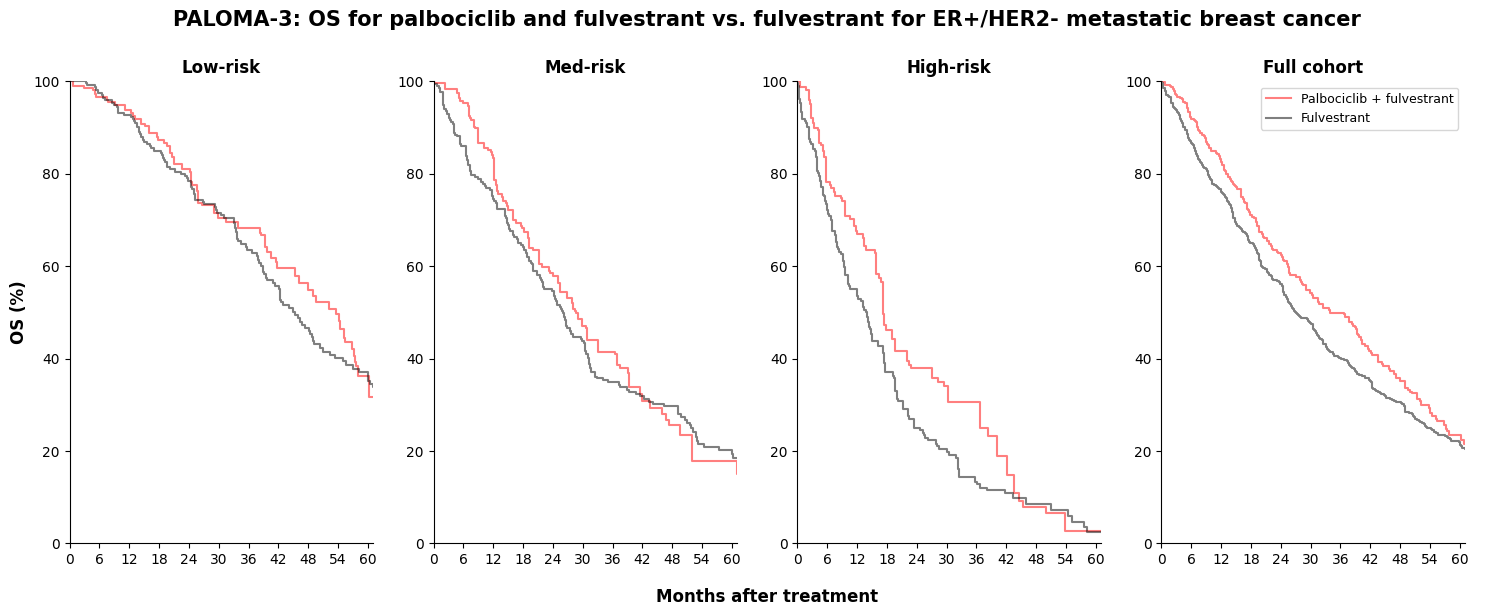

In [288]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

plt.step(kmf_low_pfulv_paloma3_iptw.timeline, kmf_low_pfulv_paloma3_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_low_fulv_paloma3_iptw.timeline, kmf_low_fulv_paloma3_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('OS (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves for med risk group. 
plt.subplot(1, 4, 2)

plt.step(kmf_med_pfulv_paloma3_iptw.timeline, kmf_med_pfulv_paloma3_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_med_fulv_paloma3_iptw.timeline, kmf_med_fulv_paloma3_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

plt.step(kmf_high_pfulv_paloma3_iptw.timeline, kmf_high_pfulv_paloma3_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_high_fulv_paloma3_iptw.timeline, kmf_high_fulv_paloma3_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for all risk group. 
plt.subplot(1, 4, 4)

plt.step(kmf_all_pfulv_paloma3_iptw.timeline, kmf_all_pfulv_paloma3_iptw.survival_function_.values*100, color = 'red', alpha = 0.5, label = 'Palbociclib + fulvestrant')

plt.step(kmf_all_fulv_paloma3_iptw.timeline, kmf_all_fulv_paloma3_iptw.survival_function_.values*100, color = 'black', alpha = 0.5, label = 'Fulvestrant')

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'upper right', prop = {'size': 9})

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title('PALOMA-3: OS for palbociclib and fulvestrant vs. fulvestrant for ER+/HER2- metastatic breast cancer', pad = 40, size = 15, weight = 'bold')

plt.show()

### CLEOPATRA: pertuzumab, trastuzumab, and docetaxel in HER2-positive metastatic breast cancer

**INCLUSION**
* Untreated metastatic breast cancer
* Received first line pertuzumab, trastuzumab, and docetaxel/paclitaxel or first line trastuzumab + docetaxel/paclitaxel 
* First line of hormonal treatment is allowed
* HER-2 positive within (+30, -inf) of receipt of treatment 
* No relevant comorbidities in the year preceding metastatic diagnosis 
* No CNS metastasis at time of treatment 
* ECOG cannot be 2, 3, or 4 at time of treatment 
* Adequate organ function at time of treatment 

#### First line trastuzumab + docetaxel/paclitaxel +/- pertuzumab 

In [289]:
df_full = pd.read_csv('df_risk_crude.csv', index_col = 'PatientID', dtype = {'death_status': bool})
df_full.index.nunique()

31677

In [290]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [291]:
tpdp = [
    'Docetaxel,Pertuzumab,Trastuzumab',
    'Docetaxel,Pertuzumab,Trastuzumab-Anns',
    'Docetaxel,Pertuzumab,Trastuzumab-Qyyp',
    'Paclitaxel,Pertuzumab,Trastuzumab',
    'Paclitaxel,Pertuzumab,Trastuzumab-Anns',
    'Paclitaxel,Pertuzumab,Trastuzumab-Qyyp',
    'Paclitaxel Protein-Bound,Pertuzumab,Trastuzumab',
    'Paclitaxel Protein-Bound,Pertuzumab,Trastuzumab-Anns',
    'Paclitaxel Protein-Bound,Pertuzumab,Trastuzumab-Qyyp']

tpdp_fl = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1')
    .query('LineName == @tpdp')
    [['PatientID', 'StartDate']]
)

In [292]:
tpdp_fl.loc[:, 'tpdp'] = 1

In [293]:
row_ID(tpdp_fl)

(1219, 1219)

In [294]:
tpd = [
    'Docetaxel,Trastuzumab',
    'Docetaxel,Trastuzumab-Anns',
    'Docetaxel,Trastuzumab-Qyyp',
    'Paclitaxel,Trastuzumab',
    'Paclitaxel,Trastuzumab-Anns',
    'Paclitaxel,Trastuzumab-Qyyp',
    'Paclitaxel Protein-Bound,Trastuzumab',
    'Paclitaxel Protein-Bound,Trastuzumab-Anns',
    'Paclitaxel Protein-Bound,Trastuzumab-Qyyp'] 

tpd_fl = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1')
    .query('LineName == @tpd')
    [['PatientID', 'StartDate']]
)

In [295]:
tpd_fl.loc[:, 'tpdp'] = 0

In [296]:
row_ID(tpdp_fl)

(1219, 1219)

#### First line endocrine therapy, second line trastuzumab + docetaxel/paclitaxel +/- pertuzumab 

In [297]:
all_treatment = line_therapy.LineName.unique()

In [298]:
treatment_list = []
for trt in all_treatment:
    treatment_list.extend(trt.split(","))

In [299]:
unique = list(dict.fromkeys(treatment_list))

In [300]:
et = [
    'Anastrozole',
    'Letrozole',
    'Exemestane',
    'Tamoxifen',
    'Leuprolide',
    'Goserelin',
    'Triptorelin']

In [301]:
unique.remove('Anastrozole')
unique.remove('Letrozole')
unique.remove('Exemestane')
unique.remove('Tamoxifen')
unique.remove('Leuprolide')
unique.remove('Goserelin')
unique.remove('Triptorelin')

In [302]:
line_therapy_fl = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1'))

In [303]:
(
    line_therapy_fl
    [line_therapy_fl['LineName'].str.contains('|'.join(et))
     & ~line_therapy_fl['LineName'].str.contains('|'.join(unique))]
    .LineName.value_counts().head(10)
)

Anastrozole               2943
Letrozole                 2536
Tamoxifen                 1305
Exemestane                 780
Leuprolide                  77
Goserelin                   60
Leuprolide,Tamoxifen        56
Letrozole,Leuprolide        40
Goserelin,Tamoxifen         36
Anastrozole,Leuprolide      35
Name: LineName, dtype: int64

In [304]:
et_id = (
    line_therapy_fl
    [line_therapy_fl['LineName'].str.contains('|'.join(et))
     & ~line_therapy_fl['LineName'].str.contains('|'.join(unique))]
    .PatientID
)

In [305]:
line_therapy_sec = (
    line_therapy[line_therapy['PatientID'].isin(et_id)]
    .query('LineNumber == 2'))

In [306]:
et_tpdp = (
    line_therapy_sec
    .query('LineName == @tpdp')
    [['PatientID', 'StartDate']]
)

In [307]:
et_tpdp.loc[:, 'tpdp'] = 1

In [308]:
row_ID(et_tpdp)

(79, 79)

In [309]:
et_tpd = (
    line_therapy_sec
    .query('LineName == @tpd')
    [['PatientID', 'StartDate']]
)

In [310]:
et_tpd.loc[:, 'tpdp'] = 0

In [311]:
row_ID(et_tpd)

(5, 5)

In [312]:
cleopatra_p = pd.concat([tpdp_fl, et_tpdp])

In [313]:
row_ID(cleopatra_p)

(1298, 1298)

In [314]:
cleopatra_np = pd.concat([tpd_fl, et_tpd])

In [315]:
row_ID(cleopatra_np)

(184, 184)

In [316]:
cleopatra = pd.concat([cleopatra_p, cleopatra_np])

In [317]:
row_ID(cleopatra)

(1482, 1482)

In [318]:
cleopatra = pd.merge(cleopatra, df_full, on = 'PatientID', how = 'left')

In [319]:
row_ID(cleopatra)

(1482, 1482)

In [320]:
cleopatra['StartDate'] = pd.to_datetime(cleopatra['StartDate'])

#### HER-2 positive

In [321]:
biomarkers = pd.read_csv('Enhanced_MetBreastBiomarkers.csv')

In [322]:
biomarkers = biomarkers[biomarkers['PatientID'].isin(cleopatra['PatientID'])]

In [323]:
row_ID(biomarkers)

(10765, 1482)

In [324]:
biomarkers = pd.merge(biomarkers, cleopatra[['PatientID', 'StartDate']], on = 'PatientID', how = 'left')

In [325]:
row_ID(biomarkers)

(10765, 1482)

In [326]:
biomarkers['StartDate'] = pd.to_datetime(biomarkers['StartDate'])

In [327]:
biomarkers['ResultDate'] = pd.to_datetime(biomarkers['ResultDate'])

In [328]:
biomarkers['SpecimenReceivedDate'] = pd.to_datetime(biomarkers['SpecimenReceivedDate'])

In [329]:
biomarkers.loc[:, 'result_date'] = (
    np.where(biomarkers['ResultDate'].isna(), biomarkers['SpecimenReceivedDate'], biomarkers['ResultDate'])
)

In [330]:
biomarkers.loc[:, 'date_diff'] = (biomarkers['result_date'] - biomarkers['StartDate']).dt.days

In [331]:
her2_rel = ['IHC negative (0-1+)',
            'FISH negative/not amplified',
            'Negative NOS',
            'NGS negative (ERBB2 not amplified)',
            'IHC positive (3+)',
            'FISH positive/amplified',
            'Positive NOS',
            'NGS positive (ERBB2 amplified)']

her2_status = (
    biomarkers
    .query('BiomarkerName == "HER2"')
    .query('date_diff <= 30')
    .query('BiomarkerStatus == @her2_rel')
    .sort_values(['PatientID', 'date_diff'], ascending = [True, False])
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    [['PatientID', 'BiomarkerStatus']]
    .rename(columns = {'BiomarkerStatus': 'her2'})
)

In [332]:
row_ID(her2_status)

(1377, 1377)

In [333]:
cleopatra = pd.merge(cleopatra, her2_status, on  = 'PatientID', how = 'left')

In [334]:
row_ID(cleopatra)

(1482, 1482)

In [335]:
her2_pos = ['IHC positive (3+)',
            'FISH positive/amplified',
            'Positive NOS',
            'NGS positive (ERBB2 amplified)']

cleopatra = (
    cleopatra
    .query('her2== @her2_pos')
)

In [336]:
row_ID(cleopatra)

(1296, 1296)

#### Time from treatment to progression/death or censor 

In [337]:
mortality_tr = pd.read_csv('mortality_cleaned_tr.csv')

In [338]:
mortality_te = pd.read_csv('mortality_cleaned_te.csv')

In [339]:
mortality_tr = mortality_tr[['PatientID', 'death_date', 'last_activity']]

In [340]:
mortality_te = mortality_te[['PatientID', 'death_date', 'last_activity']]

In [341]:
mortality = pd.concat([mortality_tr, mortality_te], ignore_index = True)
row_ID(mortality)

(31677, 31677)

In [342]:
mortality.loc[:, 'last_activity'] = pd.to_datetime(mortality['last_activity'])

In [343]:
mortality.loc[:, 'death_date'] = pd.to_datetime(mortality['death_date'])

In [344]:
row_ID(mortality)

(31677, 31677)

In [345]:
cleopatra = pd.merge(cleopatra, mortality, on = 'PatientID', how = 'left')

In [346]:
row_ID(cleopatra)

(1296, 1296)

In [347]:
conditions = [
    (cleopatra['death_status'] == 1),
    (cleopatra['death_status'] == 0)]

choices = [
    (cleopatra['death_date'] - cleopatra['StartDate']).dt.days,
    (cleopatra['last_activity'] - cleopatra['StartDate']).dt.days]

cleopatra.loc[:, 'timerisk_treatment'] = np.select(conditions, choices)

In [348]:
cleopatra = cleopatra.query('timerisk_treatment >= 0')

#### Patient count 

In [349]:
row_ID(cleopatra)

(1294, 1294)

In [350]:
# Exclude those with CNS metastatsis at time of metastatic diagnosis 
cleopatra = cleopatra[~cleopatra['PatientID'].isin(cns_fl_IDs)]

In [351]:
# Exlcude those with cardiac comorbidities
cleopatra = cleopatra[~cleopatra['PatientID'].isin(cardiac_IDs)]

In [352]:
# Exlcude those with other relevant comorbidities
cleopatra = cleopatra[~cleopatra['PatientID'].isin(other_comorb_IDs)]

In [353]:
# Exclude those with ECOG 2, 3, or 4
cleopatra = cleopatra[~cleopatra['PatientID'].isin(ecog_fl_234_IDs)]

In [354]:
# Exclude those with abnormal organ function at time of second line treatment 
cleopatra = cleopatra[~cleopatra['PatientID'].isin(ab_organ_fl_IDs)]

In [355]:
row_ID(cleopatra)

(1005, 1005)

In [356]:
low_cutoff_cleopatra = cutoff.loc['cleopatra'].low

In [357]:
high_cutoff_cleopatra = cutoff.loc['cleopatra'].high

In [358]:
print('Pertuzumab + trastuzumab + docetaxel/paclitaxel total:',  cleopatra.query('tpdp == 1').shape[0])
print('High risk:', cleopatra.query('tpdp == 1').query('risk_score >= @high_cutoff_cleopatra').shape[0])
print('Med risk:', cleopatra.query('tpdp == 1').query('risk_score < @high_cutoff_cleopatra and risk_score > @low_cutoff_cleopatra').shape[0])
print('Low risk:', cleopatra.query('tpdp == 1').query('risk_score <= @low_cutoff_cleopatra').shape[0])

Pertuzumab + trastuzumab + docetaxel/paclitaxel total: 892
High risk: 219
Med risk: 321
Low risk: 352


In [359]:
print('Trastuzumab + docetaxel/paclitaxel total:',  cleopatra.query('tpdp == 0').shape[0])
print('High risk:', cleopatra.query('tpdp == 0').query('risk_score >= @high_cutoff_cleopatra').shape[0])
print('Med risk:', cleopatra.query('tpdp == 0').query('risk_score < @high_cutoff_cleopatra and risk_score > @low_cutoff_cleopatra').shape[0])
print('Low risk:', cleopatra.query('tpdp == 0').query('risk_score <= @low_cutoff_cleopatra').shape[0])

Trastuzumab + docetaxel/paclitaxel total: 113
High risk: 39
Med risk: 35
Low risk: 39


#### Survival curves with covaraite balancing 

In [360]:
conditions = [
    (cleopatra['thorax_met'] == 1) |
    (cleopatra['liver_met'] == 1) |
    (cleopatra['cns_met'] == 1) |
    (cleopatra['peritoneum_met'] == 1) |
    (cleopatra['other_met'] == 1),
    (cleopatra['bone_met'] == 0) &
    (cleopatra['thorax_met'] == 0) &
    (cleopatra['lymph_met'] == 0) &
    (cleopatra['liver_met'] == 0) &
    (cleopatra['cns_met'] == 0) &
    (cleopatra['skin_met'] == 0) &
    (cleopatra['peritoneum_met'] == 0) &
    (cleopatra['other_met'] == 0)
]

choices = ['visceral', 'unknown']

cleopatra['met_site'] = np.select(conditions, choices, default = 'nonvisceral')

In [361]:
cleopatra['met_cat'] = pd.cut(cleopatra['met_year'],
                              bins = [2010, 2016, float('inf')],
                              labels = ['11-16', '17-22'])

In [362]:
conditions = [
    ((cleopatra['ecog_diagnosis'] == "1.0") | (cleopatra['ecog_diagnosis'] == "0.0")),  
    ((cleopatra['ecog_diagnosis'] == "2.0") | (cleopatra['ecog_diagnosis'] == "3.0"))
]

choices = ['lt_2', 'gte_2']

cleopatra['ecog_2'] = np.select(conditions, choices, default = 'unknown')

In [363]:
conditions = [
    ((cleopatra['ses'] == 1) | (cleopatra['ses'] == 2) | (cleopatra['ses'] == 3)), 
    ((cleopatra['ses'] == 4) | (cleopatra['ses'] == 5))
]

choices = ['lt_4', 'gte_4']

cleopatra['ses_cat'] = np.select(conditions, choices, default = 'unknown')

In [364]:
cleopatra['race_cat'] = np.where(cleopatra['race'] == "White", 1, 0)

In [365]:
cleopatra = cleopatra.set_index('PatientID')

In [366]:
cleopatra_iptw = cleopatra.filter(items = ['death_status',
                                           'timerisk_treatment',
                                           'tpdp',
                                           'age',
                                           'gender',
                                           'race_cat',
                                           'p_type',
                                           'delta_met_diagnosis',
                                           'met_cat',
                                           'ses_cat',
                                           'ecog_2',
                                           'risk_score'])

In [367]:
cleopatra_iptw.dtypes

death_status               bool
timerisk_treatment      float64
tpdp                      int64
age                       int64
gender                   object
race_cat                  int64
p_type                   object
delta_met_diagnosis       int64
met_cat                category
ses_cat                  object
ecog_2                   object
risk_score              float64
dtype: object

In [368]:
to_be_categorical = list(cleopatra_iptw.select_dtypes(include = ['object']).columns)

In [369]:
to_be_categorical

['gender', 'p_type', 'ses_cat', 'ecog_2']

In [370]:
to_be_categorical.append('met_cat')

In [371]:
to_be_categorical.append('race_cat')

In [372]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    cleopatra_iptw[x] = cleopatra_iptw[x].astype('category')

In [373]:
# List of numeric variables, excluding binary variables. 
numerical_features = ['age', 'delta_met_diagnosis']

# Transformer will first calculate column median and impute, and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [374]:
# List of categorical features.
categorical_features = list(cleopatra_iptw.select_dtypes(include = ['category']).columns)

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [375]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

In [376]:
cleopatra_iptw_low = (
    cleopatra_iptw
    .query('risk_score <= @low_cutoff_cleopatra')
    .drop(columns = ['risk_score']))

cleopatra_iptw_med = (
    cleopatra_iptw
    .query('risk_score < @high_cutoff_cleopatra and risk_score > @low_cutoff_cleopatra')
    .drop(columns = ['risk_score']))

cleopatra_iptw_high = (
    cleopatra_iptw
    .query('risk_score >= @high_cutoff_cleopatra')
    .drop(columns = ['risk_score']))

cleopatra_iptw_all = (
    cleopatra_iptw
    .drop(columns = ['risk_score']))

In [377]:
cleopatra_low_x = preprocessor.fit_transform(cleopatra_iptw_low.filter(items = ['age',
                                                                                'gender',
                                                                                'race_cat',
                                                                                'p_type',
                                                                                'delta_met_diagnosis',
                                                                                'met_cat',
                                                                                'ses_cat',
                                                                                'ecog_2']))

cleopatra_med_x = preprocessor.fit_transform(cleopatra_iptw_med.filter(items = ['age',
                                                                                'gender',
                                                                                'race_cat',
                                                                                'p_type',
                                                                                'delta_met_diagnosis',
                                                                                'met_cat',
                                                                                'ses_cat',
                                                                                'ecog_2']))

cleopatra_high_x = preprocessor.fit_transform(cleopatra_iptw_high.filter(items = ['age',
                                                                                  'gender',
                                                                                  'race_cat',
                                                                                  'p_type',
                                                                                  'delta_met_diagnosis',
                                                                                  'met_cat',
                                                                                  'ses_cat',
                                                                                  'ecog_2']))

cleopatra_all_x = preprocessor.fit_transform(cleopatra_iptw_all.filter(items = ['age',
                                                                                'gender',
                                                                                'race_cat',
                                                                                'p_type',
                                                                                'delta_met_diagnosis',
                                                                                'met_cat',
                                                                                'ses_cat',
                                                                                'ecog_2']))

In [378]:
lr_cleopatra_low = LogisticRegression(max_iter = 1000)
lr_cleopatra_low.fit(cleopatra_low_x, cleopatra_iptw_low['tpdp'])

LogisticRegression(max_iter=1000)

In [379]:
lr_cleopatra_med = LogisticRegression(max_iter = 1000)
lr_cleopatra_med.fit(cleopatra_med_x, cleopatra_iptw_med['tpdp'])

LogisticRegression(max_iter=1000)

In [380]:
lr_cleopatra_high = LogisticRegression(max_iter = 1000)
lr_cleopatra_high.fit(cleopatra_high_x, cleopatra_iptw_high['tpdp'])

LogisticRegression(max_iter=1000)

In [381]:
lr_cleopatra_all = LogisticRegression(max_iter = 1000)
lr_cleopatra_all.fit(cleopatra_all_x, cleopatra_iptw_all['tpdp'])

LogisticRegression(max_iter=1000)

In [382]:
pred_low = lr_cleopatra_low.predict_proba(cleopatra_low_x)
pred_med = lr_cleopatra_med.predict_proba(cleopatra_med_x)
pred_high = lr_cleopatra_high.predict_proba(cleopatra_high_x)
pred_all = lr_cleopatra_all.predict_proba(cleopatra_all_x)

In [383]:
cleopatra_iptw_low['ps'] = pred_low[:, 1]
cleopatra_iptw_med['ps'] = pred_med[:, 1]
cleopatra_iptw_high['ps'] = pred_high[:, 1]
cleopatra_iptw_all['ps'] = pred_all[:, 1]

In [384]:
cleopatra_iptw_low['weight'] = (
    np.where(cleopatra_iptw_low['tpdp'] == 1, 1/cleopatra_iptw_low['ps'], 1/(1 - cleopatra_iptw_low['ps'])))

cleopatra_iptw_med['weight'] = (
    np.where(cleopatra_iptw_med['tpdp'] == 1, 1/cleopatra_iptw_med['ps'], 1/(1 - cleopatra_iptw_med['ps'])))

cleopatra_iptw_high['weight'] = (
    np.where(cleopatra_iptw_high['tpdp'] == 1, 1/cleopatra_iptw_high['ps'], 1/(1 - cleopatra_iptw_high['ps'])))

cleopatra_iptw_all['weight'] = (
    np.where(cleopatra_iptw_all['tpdp'] == 1, 1/cleopatra_iptw_all['ps'], 1/(1 - cleopatra_iptw_all['ps'])))

In [385]:
# Low KM curves
kmf_low_tpdp_cleopatra_iptw = KaplanMeierFitter()
kmf_low_tdp_cleopatra_iptw = KaplanMeierFitter()

kmf_low_tpdp_cleopatra_iptw.fit(
    cleopatra_iptw_low.query('tpdp == 1')['timerisk_treatment']/30,
    cleopatra_iptw_low.query('tpdp == 1')['death_status'],
    weights = cleopatra_iptw_low.query('tpdp == 1')['weight'])

kmf_low_tdp_cleopatra_iptw.fit(
    cleopatra_iptw_low.query('tpdp == 0')['timerisk_treatment']/30,
    cleopatra_iptw_low.query('tpdp == 0')['death_status'],
    weights = cleopatra_iptw_low.query('tpdp == 0')['weight'])

# Med KM curves
kmf_med_tpdp_cleopatra_iptw = KaplanMeierFitter()
kmf_med_tdp_cleopatra_iptw = KaplanMeierFitter()

kmf_med_tpdp_cleopatra_iptw.fit(
    cleopatra_iptw_med.query('tpdp == 1')['timerisk_treatment']/30,
    cleopatra_iptw_med.query('tpdp == 1')['death_status'], 
    weights = cleopatra_iptw_med.query('tpdp == 1')['weight'])

kmf_med_tdp_cleopatra_iptw.fit(
    cleopatra_iptw_med.query('tpdp == 0')['timerisk_treatment']/30,
    cleopatra_iptw_med.query('tpdp == 0')['death_status'], 
    weights = cleopatra_iptw_med.query('tpdp == 0')['weight'])

# High KM curves 
kmf_high_tpdp_cleopatra_iptw = KaplanMeierFitter()
kmf_high_tdp_cleopatra_iptw = KaplanMeierFitter()

kmf_high_tpdp_cleopatra_iptw.fit(
    cleopatra_iptw_high.query('tpdp == 1')['timerisk_treatment']/30,
    cleopatra_iptw_high.query('tpdp == 1')['death_status'], 
    weights = cleopatra_iptw_high.query('tpdp == 1')['weight'])

kmf_high_tdp_cleopatra_iptw.fit(
    cleopatra_iptw_high.query('tpdp == 0')['timerisk_treatment']/30,
    cleopatra_iptw_high.query('tpdp == 0')['death_status'], 
    weights = cleopatra_iptw_high.query('tpdp == 0')['weight'])

# All KM curves 
kmf_all_tpdp_cleopatra_iptw = KaplanMeierFitter()
kmf_all_tdp_cleopatra_iptw = KaplanMeierFitter()

kmf_all_tpdp_cleopatra_iptw.fit(
    cleopatra_iptw_all.query('tpdp == 1')['timerisk_treatment']/30,
    cleopatra_iptw_all.query('tpdp == 1')['death_status'], 
    weights = cleopatra_iptw_all.query('tpdp == 1')['weight'])

kmf_all_tdp_cleopatra_iptw.fit(
    cleopatra_iptw_all.query('tpdp == 0')['timerisk_treatment']/30,
    cleopatra_iptw_all.query('tpdp == 0')['death_status'], 
    weights = cleopatra_iptw_all.query('tpdp == 0')['weight'])

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:344: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  StatisticalWarning,


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 936.338 total observations, 303.26 right-censored observations>

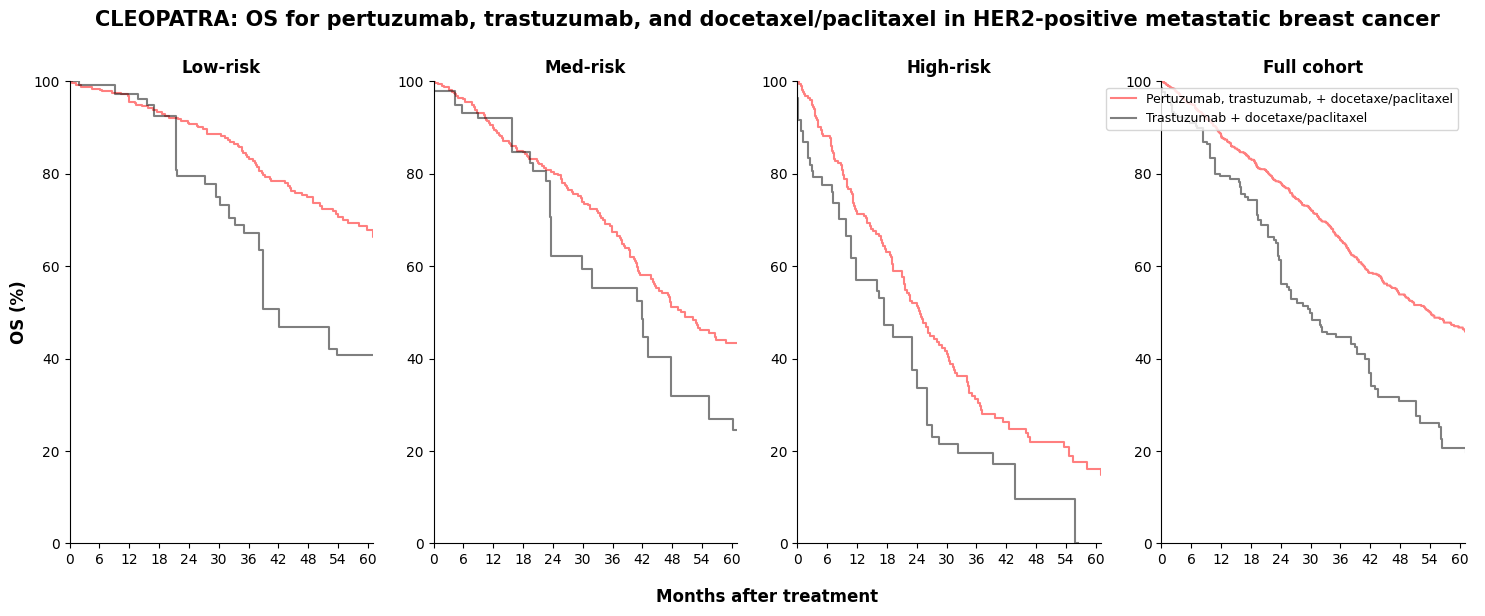

In [386]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

plt.step(kmf_low_tpdp_cleopatra_iptw.timeline, kmf_low_tpdp_cleopatra_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_low_tdp_cleopatra_iptw.timeline, kmf_low_tdp_cleopatra_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('OS (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves for med risk group. 
plt.subplot(1, 4, 2)

plt.step(kmf_med_tpdp_cleopatra_iptw.timeline, kmf_med_tpdp_cleopatra_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_med_tdp_cleopatra_iptw.timeline, kmf_med_tdp_cleopatra_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

plt.step(kmf_high_tpdp_cleopatra_iptw.timeline, kmf_high_tpdp_cleopatra_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_high_tdp_cleopatra_iptw.timeline, kmf_high_tdp_cleopatra_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for all risk group. 
plt.subplot(1, 4, 4)

plt.step(kmf_all_tpdp_cleopatra_iptw.timeline, kmf_all_tpdp_cleopatra_iptw.survival_function_.values*100, color = 'red', alpha = 0.5, label = 'Pertuzumab, trastuzumab, + docetaxe/paclitaxel')

plt.step(kmf_all_tdp_cleopatra_iptw.timeline, kmf_all_tdp_cleopatra_iptw.survival_function_.values*100, color = 'black', alpha = 0.5, label = 'Trastuzumab + docetaxe/paclitaxel')

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'upper right', prop = {'size': 9})

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title('CLEOPATRA: OS for pertuzumab, trastuzumab, and docetaxel/paclitaxel in HER2-positive metastatic breast cancer', pad = 40, size = 15, weight = 'bold')

plt.show()